In [1]:
# standard lib
import sqlite3
import io
import time

# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# utils
from tqdm.notebook import tqdm

# chess
import chess
import chess
import chess.pgn
import chess.engine

# my custom libs
from gameeval import landscapeeval, gameeval
# from mmaformatter import save_as_mma

In [2]:
con = sqlite3.connect('data.db')
cur = con.cursor()

In [3]:
query = "SELECT * FROM games"
df = pd.read_sql_query(query, con)

In [6]:
# selected_games = df.iloc[np.random.choice(df.shape[0], size=100),:]

In [8]:
# selected_games.to_csv("selected_games_for_compare_engine_depth.csv")

In [ ]:
selected_games = pd.read_csv("selected_games_for_compare_engine_depth.csv")

In [11]:
def benchmark_game(game_str, engine, depths):

    # make pgn string of moves into python-chess game object
    pgn = io.StringIO(game_str)
    game = chess.pgn.read_game(pgn)

    # run eval for game and save metrics
    results_cp = []
    results_wdl = []
    times = []
    for depth in depths:
        start = time.time()
        cps, wdls = gameeval(game, engine, depth=depth)
        end = time.time()
        results_cp.append(cps)
        results_wdl.append(wdls)
        times.append(end-start)
        
    return times, results_cp, results_wdl

In [15]:
# Path to stockfish engine
engine = chess.engine.SimpleEngine.popen_uci("/usr/local/Cellar/stockfish/17/bin/stockfish")

In [16]:
results = []
depths = [5, 10, 15, 20]
for game_str in tqdm(selected_games["Moves"]):
    times, results_cp, results_wdl = benchmark_game(game_str, engine, depths)
    results.append((times, results_cp, results_wdl))

  0%|          | 0/100 [00:00<?, ?it/s]

- Rapid, Blitz, Bullet (33,000 of each)
- k=5, d=2, possibly save the line for the leaf nodes?

In [45]:
# save results to disk
# np.save("depth_compare_results.npy", np.array(results, dtype="object"), allow_pickle=True)

In [47]:
# results = np.load("depth_compare_results.npy", allow_pickle=True)

In [67]:
times = np.array([r[0] for r in results])

In [68]:
# really this is the number of moves analyzed (the actual game lengths are 1 move longer)
game_lengths = np.array([r[1][0].shape[0] for r in results])

In [70]:
# divide by the number of moves to get the time per move
times_per_move = np.zeros(times.shape)
for i in range(4):
    times_per_move[:,i] = times[:,i]/game_lengths

In [74]:
times_per_move.mean(axis=0)

array([0.00221742, 0.01091297, 0.10183028, 0.88194988])

Text(0.5, 1.0, 'Time per move (averaged over games)')

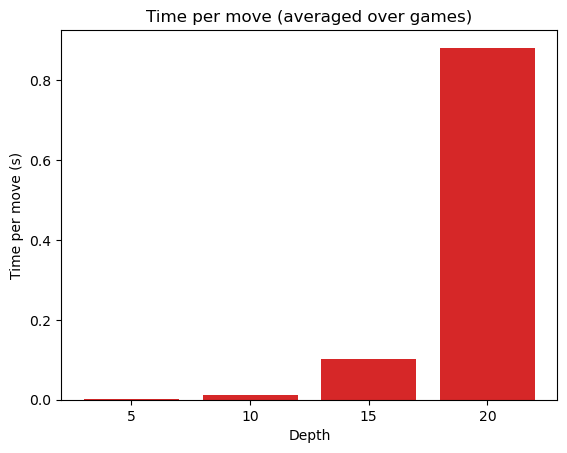

In [75]:
# average times per move over games
fig, ax = plt.subplots()
for i, depth in enumerate(depths):
    ax.bar([str(d) for d in depths], times_per_move.mean(axis=0))
# ax.legend()
ax.set_xlabel("Depth")
ax.set_ylabel("Time per move (s)")
ax.set_title("Time per move (averaged over games)")

In [79]:
centipawns = [r[1] for r in results]

In [86]:
from matplotlib.lines import Line2D

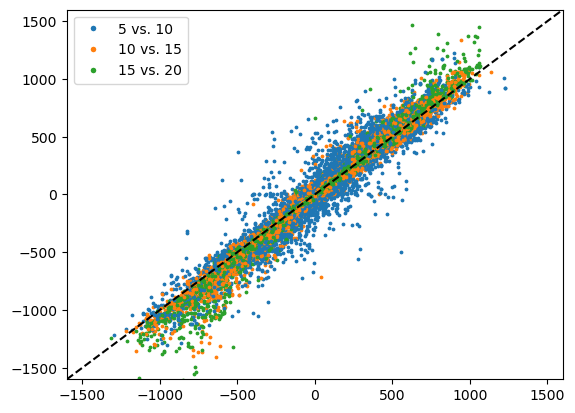

In [96]:
# scatter plot depth pairs against each other for all games for centipawn scores
fig, ax = plt.subplots()
colors = ["C0", "C1", "C2"]
labels = ["5 vs. 10", "10 vs. 15", "15 vs. 20"]
for results_cp in centipawns:
    for i in range(1, len(results_cp)):
        ax.scatter(results_cp[i-1], results_cp[i], s=3, color=colors[i-1])
minlim, maxlim = -1600, 1600
ax.plot(range(minlim, maxlim), range(minlim, maxlim), linestyle="--", color="k")
ax.set_xlim(minlim, maxlim)
ax.set_ylim(minlim, maxlim)

legend_elements = [Line2D([0], [0], color='w', markerfacecolor=colors[i], 
                          marker='o', label=labels[i], markersize=5) for i in range(len(colors))]
ax.legend(handles=legend_elements)

In [98]:
wdls = [r[2] for r in results]

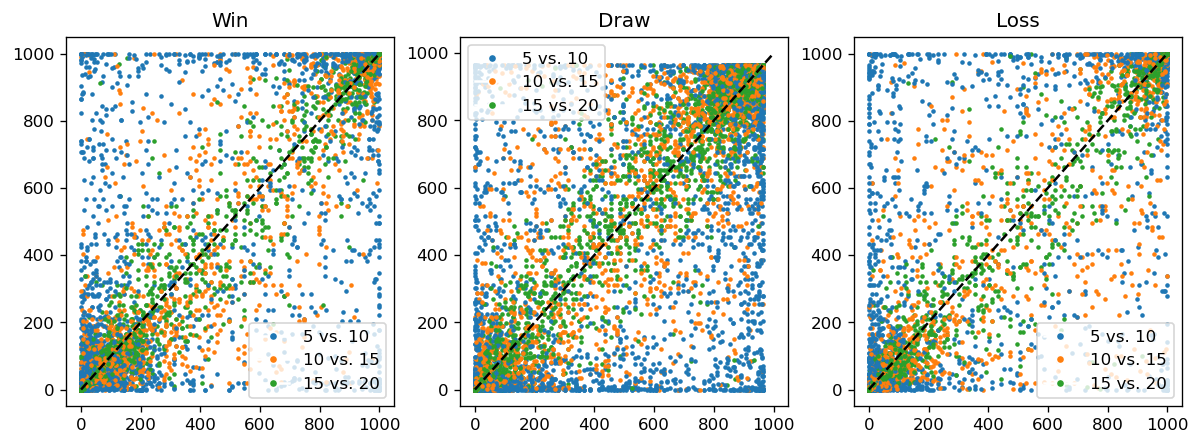

In [104]:
# scatter plot improvements against each other for all games for WDL scores
fig, axes = plt.subplots(1,3,figsize=(12,4), dpi=120)
colors = ["C0", "C1", "C2"]
labels = ["5 vs. 10", "10 vs. 15", "15 vs. 20"]
titles = ["Win", "Draw", "Loss"]
legend_elements = [Line2D([0], [0], color='w', markerfacecolor=colors[i], 
                          marker='o', label=labels[i], markersize=5) for i in range(len(colors))]
for j in range(3): # j is w, d, l
    ax = axes[j]
    wdl = [[s[:,j] for s in w] for w in wdls]
    for results_wdl in wdl:
        for i in range(1, len(results_wdl)):
            ax.scatter(results_wdl[i-1], results_wdl[i], s=3, color=colors[i-1])
    minlim, maxlim = 0, 1000
    ax.plot(range(minlim, maxlim), range(minlim, maxlim), linestyle="--", color="k")
    ax.legend(handles=legend_elements)
    ax.set_title(titles[j])

In [106]:
df["Event"].value_counts()

Event
Rated Blitz game                                                      45388
Rated Classical game                                                  41772
Rated Bullet game                                                     32691
Rated Correspondence game                                               266
Rated Blitz tournament https://lichess.org/tournament/eaxo4pkh           18
                                                                      ...  
Rated Classical tournament https://lichess.org/tournament/dshcjgey        2
Rated Blitz tournament https://lichess.org/tournament/dbu4m3u3            2
Rated Blitz tournament https://lichess.org/tournament/uitsh1pw            2
Rated Bullet tournament https://lichess.org/tournament/k4se9ydi           1
Rated Blitz tournament https://lichess.org/tournament/lpotikyv            1
Name: count, Length: 151, dtype: int64

In [107]:
df.shape

(121332, 22)

In [111]:
df["TimeControl"].value_counts().head(20)

TimeControl
60+0     14525
300+0    10187
180+0     8243
0+1       7028
120+0     5951
300+8     5500
300+5     4309
240+0     3850
180+3     3034
300+2     2992
60+1      2966
600+0     2452
900+0     1882
480+0     1787
420+0     1696
300+3     1651
600+8     1311
360+0     1300
120+2     1212
180+2     1194
Name: count, dtype: int64

In [113]:
(df["Event"]+" "+df["TimeControl"]).value_counts().head(20)

Rated Bullet game 60+0        14463
Rated Blitz game 300+0        10009
Rated Blitz game 180+0         8077
Rated Bullet game 0+1          6999
Rated Bullet game 120+0        5824
Rated Classical game 300+8     5500
Rated Classical game 300+5     4309
Rated Blitz game 240+0         3792
Rated Blitz game 180+3         3034
Rated Bullet game 60+1         2943
Rated Blitz game 300+2         2859
Rated Classical game 600+0     2452
Rated Classical game 900+0     1882
Rated Classical game 480+0     1787
Rated Blitz game 420+0         1674
Rated Blitz game 300+3         1651
Rated Classical game 600+8     1311
Rated Blitz game 360+0         1257
Rated Blitz game 180+2         1144
Rated Blitz game 120+2         1104
Name: count, dtype: int64

In [114]:
pgn_file = "/Volumes/Extreme SSD/chessdata/lichess_db_standard_rated_2024-06.pgn"

In [132]:
games_count = 0
games = []
with open(pgn_file, "r") as f:
    previous_line = ""
    game_text = ""
    for line in f:
        game_text += line
        # fetch lines until the end of the game is reached
        # then save that game to the db
        # then 'clear' the game so we can fetch the next game
        if previous_line.startswith("1. "):
            games_count += 1
            # pgn_dict = build_pgn_dict(game_text)
            # save_game_to_db(cursor, pgn_dict)
            games.append(game_text)
            game_text = ""
            if games_count == 500:
                break
        previous_line = line

In [143]:
events = ["Rated Blitz game", "Rated Bullet game", "Rated Rapid game", "Rated Classical game"]
time_control = ["60+0", "300+0", "600+0", "1800+0"]

In [142]:
list(zip([g.split("]")[0] for g in games], [g.split("]")[15] for g in games]))

[('[Event "Rated Bullet game"', '\n[ECO "A15"'),
 ('[Event "UltraBullet swiss https://lichess.org/swiss/UPY2aIV2"',
  '\n\n 0-1\n\n[Event "UltraBullet swiss https://lichess.org/swiss/UPY2aIV2"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Rated Blitz game"', '\n[TimeControl "300+3"'),
 ('[Event "Bullet swiss https://lichess.org/swiss/OgU8kUYZ"',
  '\n[TimeControl "120+1"'),
 ('[Event "Bullet

In [148]:
(89000000*10/120000)/60

123.61111111111111

In [153]:
[g.split("]")[7] for g in games]

['\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.06.01"',
 '\n[UTCDate "2024.0